<h2 align=center> Toxic Comments Classification using 1D CNN with Keras</h2>

### Task 1: Import Packages and Functions

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.2.0


### Task 2: Load and Explore Data

In [2]:
# Load data

In [4]:
train_df= pd.read_csv('train.csv').fillna(' ')
train_df.sample(10, random_state=1)

,comment_text,toxic
24915,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1
75819,Agent X2: Basically thanks - with a 'little' m...,0
53891,Why are my posts being deleted? \n\nI have tri...,0
154159,"""\n\n Controlled Demolitions and Common Sense ...",0
13040,I do not understand your reply. //Blaxthos ( ...,0
123190,Is this the bizarro world? Removing content is...,0
33626,"Well, WP:RS says that articles should use reli...",0
1150,Oh hear me go someone removes all my pages i g...,0
48633,can't believe this article was deleted\nI'm su...,0
42817,"""\n\n Comments on GamerGate Workshop page \n\n...",0


In [5]:
# View few toxic comments
x = train_df['comment_text'].values
print(x)

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
 ...
 'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.'
 'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.'
 '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead o

In [6]:
# View few toxic comments
train_df.loc[train_df['toxic']==1].sample(10,random_state=10)

,comment_text,toxic
30575,"""\n Are you asking if we would ever block some...",1
36038,Amen my sock-pupinski brother!! Hack-a-long: p...,1
19730,JUST READ THE FUCKING CENSUS DATA. Do you thin...,1
72261,u no wat ass hole go fuck your self and stop b...,1
77923,Go fuck yourself \n\nEat shit and die. 68.0.11...,1
16382,A big thank you\n\nYou have just blocked me in...,1
41247,A message from Jasonceyre \n\n f uc k you ho...,1
69311,"I'm gonna get the ACLU on you, you racist anti...",1
142032,"Hey Freepsbane, does your mother know that you...",1
5613,You guys suk. You really really suck. Fuck you...,1


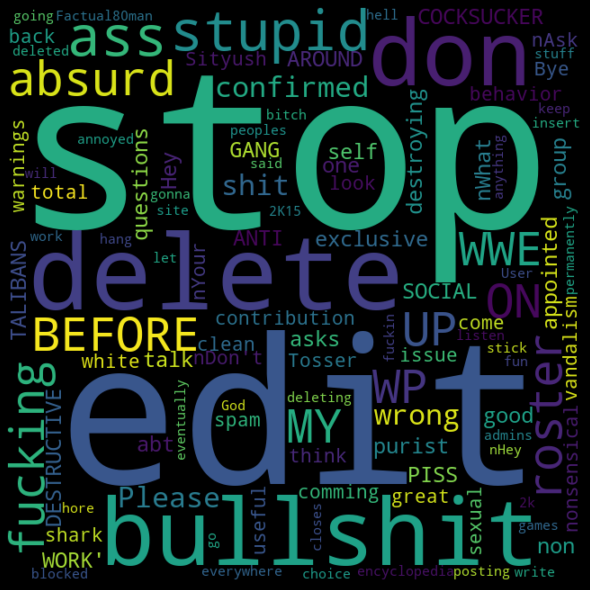

In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
comments = train_df['comment_text'].loc[train_df['toxic']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [8]:
y = train_df['toxic'].values
print(y)

[0 0 0 ... 0 0 0]


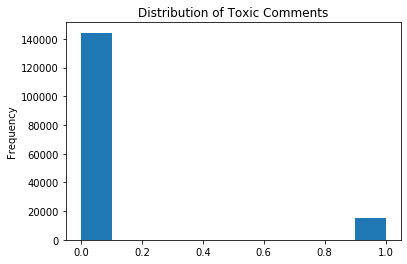

In [12]:
# Plot frequency of toxic comments
train_df['toxic'].plot(kind='hist', title='Distribution of Toxic Comments')

In [13]:
train_df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

As it can be seen data is highly unbalanced

### Task 3: Data Prep — Tokenize and Pad Text Data

In [14]:
max_features = 20000
max_text_length = 400

In [16]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val = sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

### Task 4: Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [18]:
embedding_dim = 100
embeddings_index= dict()
f= open('glove.6B.100d.txt')
for line in f:
    values= line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [19]:
print(f'Found {len(embeddings_index)} word vectors')

Found 400000 word vectors


In [31]:
#x_tokenizer.word_index.items()

In [32]:
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if(index>max_features-1):
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if(embedding_vector is not None):
            embedding_matrix[index] = embedding_vector

### Task 5: Create the Embedding Layer

In [33]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, 
                    embeddings_initializer=tf.keras.initializers.Constant(
                    embedding_matrix), trainable=False))
model.add(Dropout(0.2))

### Task 6: Build the Model

In [34]:
filters= 250
kernel_size = 3
hidden_dims = 250

In [37]:
model.add(Conv1D(filters, kernel_size, padding='valid'))   # 1D kernel (size)
model.add(MaxPooling1D())
model.add(Conv1D(filters, 5, padding='valid', activation='relu'))   # 1D kernel (size)
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu')) # Intermediate Dense Layer 
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 250)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               6

In [39]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

### Task 7: Train Model

In [40]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y, 
                                                  test_size=0.15, 
                                                  random_state=1)

In [42]:
%%time
batch_size = 64
epocs = 6
history=model.fit(x_train, y_train, 
         batch_size=batch_size, 
         epochs=epocs, verbose=1, 
         validation_data=(x_val, y_val))

Epoch 1/6
2120/2120 [==============================] - 67s 31ms/step - loss: 0.1524 - accuracy: 0.9447 - val_loss: 0.1299 - val_accuracy: 0.9535
Epoch 2/6
2120/2120 [==============================] - 67s 31ms/step - loss: 0.1306 - accuracy: 0.9517 - val_loss: 0.1183 - val_accuracy: 0.9558
Epoch 3/6
2120/2120 [==============================] - 67s 32ms/step - loss: 0.1212 - accuracy: 0.9541 - val_loss: 0.1238 - val_accuracy: 0.9550
Epoch 4/6
2120/2120 [==============================] - 67s 31ms/step - loss: 0.1153 - accuracy: 0.9567 - val_loss: 0.1204 - val_accuracy: 0.9550
Epoch 5/6
2120/2120 [==============================] - 68s 32ms/step - loss: 0.1071 - accuracy: 0.9595 - val_loss: 0.1189 - val_accuracy: 0.9568
Epoch 6/6
2120/2120 [==============================] - 67s 32ms/step - loss: 0.1007 - accuracy: 0.9620 - val_loss: 0.1182 - val_accuracy: 0.9560
CPU times: user 5min 33s, sys: 59.4 s, total: 6min 32s
Wall time: 7min 21s


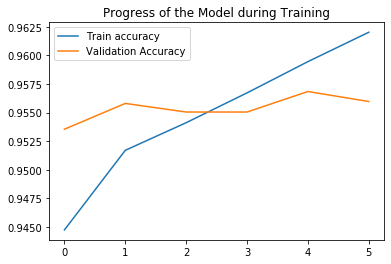

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train accuracy', 'Validation Accuracy'])
plt.title('Progress of the Model during Training')
plt.show()

### Task 8: Evaluate Model

In [44]:
test_df = pd.read_csv('test.csv')

In [45]:
x_test = test_df['comment_text'].values

In [46]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)

In [47]:
y_testing = model.predict(x_testing, verbose=1, batch_size=64)

2394/2394 [==============================] - 29s 12ms/step


In [49]:
print(y_testing.shape)
y_testing[0]

(153164, 1)


array([0.9997211], dtype=float32)

In [51]:
test_df['predictions'] = ['NonToxic' if x<0.5 else 'Toxic' for x in y_testing]

In [54]:
test_df[['comment_text', 'predictions']].head(20) #.sample(20, random_state=1)

,comment_text,predictions
0,Yo bitch Ja Rule is more succesful then you'll...,Toxic
1,== From RfC == \n\n The title is fine as it is...,NonToxic
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",NonToxic
3,":If you have a look back at the source, the in...",NonToxic
4,I don't anonymously edit articles at all.,NonToxic
5,Thank you for understanding. I think very high...,NonToxic
6,Please do not add nonsense to Wikipedia. Such ...,NonToxic
7,:Dear god this site is horrible.,NonToxic
8,""" \n Only a fool can believe in such numbers. ...",Toxic
9,== Double Redirects == \n\n When fixing double...,NonToxic
